In [1]:
%reset -s -f

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [3]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.4')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [4]:
import warnings
warnings.filterwarnings('once')

In [5]:
# reload packages from notebook whenever needed
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# import arviz as az # For visualization and loo
import seaborn as sns 

**Model**: We have two independent variables (covariates), $x1$ and $x2$, and two unknown latent parameters $\alpha$ and $\beta$. The independent data $y$ is generated as follows. First, a coin is flipped and if it is heads, then $y = 0$. Otherwise, $y$ is drawn according to a Poisson random variable. This is typically called a "zero-inflated Poisson" model. 

The coin flip is heads with probability $logit^{-1}(\alpha x_1)$. The Poisson random variable has rate $e^{\beta x_2}$. 

Our prior is that $\alpha, \beta$ are both drawn from a uniform random variable between -1 and 1. The covariates are both drawn from a Normal distribution with mean 0 and variance 1. 

# Write the statistical model down in math.
In other words, what are the distributions from which $x_1, x_2, \alpha, \beta, y$ are sampled?

Either using LaTeX within markdown, or inserting an image with math into the markdown. 

$x_1\sim \textrm{Normal}(0,1)$

$x_2\sim \textrm{Normal}(0,1)$

$\alpha\sim \textrm{Uniform}(-1,1)$

$\beta\sim \textrm{Uniform}(-1,1)$

$y \sim Bernoulli(1 - logit^{-1}(\alpha*x_1))\times Poisson(e^{\beta*x_2})$

# Generate data from the true model, given fixed parameters $\alpha, \beta$

In [7]:
from scipy import stats
from scipy.stats import bernoulli, norm, poisson

def inv_logit(v):
    return 1/(1+np.exp(-v))

# the output should be a dataframe with columns x1, x2, y
def generate_data(theta, N):
    alpha, beta = theta #as in lecture, theta = (alpha, beta)
    x1 = norm.rvs(size=N)
    x2 = norm.rvs(size=N)
    # in bernoulli output 1 = head, 0 = tail
    C = bernoulli.rvs(inv_logit(alpha * x1), size=N)
    
    # now 1 = tail, 0 = head
    # C = np.logical_not(C)
    
    poi = poisson.rvs(np.exp(beta * x2), size=N)
    
    # poisson draw is kept for tail, 0 for head
    y = C * poi
    data = {'x1':x1, 'x2':x2, 'y':y}
    d = pd.DataFrame.from_dict(data)
    return d

In [8]:
def plot_generated_data(df):
    sns.histplot(df.y)
    plt.yscale('log')
    plt.show()
    
    cuts = pd.DataFrame({str(feature) + 'Bin' : pd.qcut(df[feature], 5) for feature in ['x1', 'x2']})
    dfplot = pd.concat([df, cuts], axis=1)[['y', 'x1Bin', 'x2Bin']].groupby(['x1Bin', 'x2Bin']).mean().reset_index()
    dfpivot = dfplot.pivot(index='x1Bin', columns='x2Bin', values='y')
    plt.clf()
    sns.heatmap(dfpivot) 
    plt.title('Means of y vs Features x1 and x2')
    plt.tight_layout()
    plt.show()

The below will plot the data once you have filled out the above function

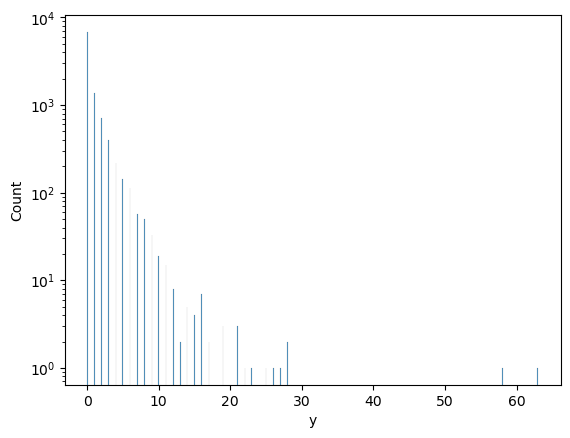

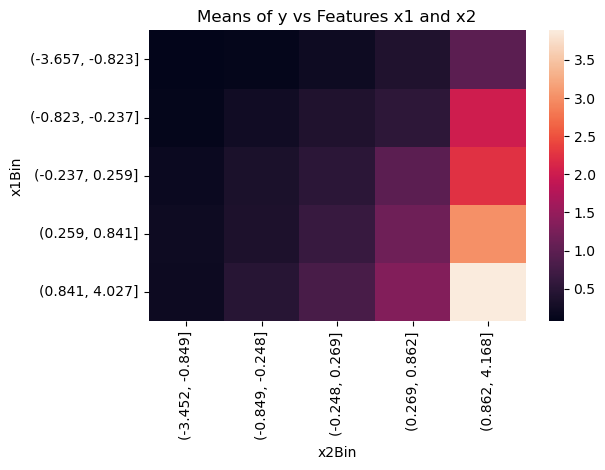

In [9]:
alpha, beta = (1, 1)
df = generate_data((alpha, beta), 10000)
plot_generated_data(df)

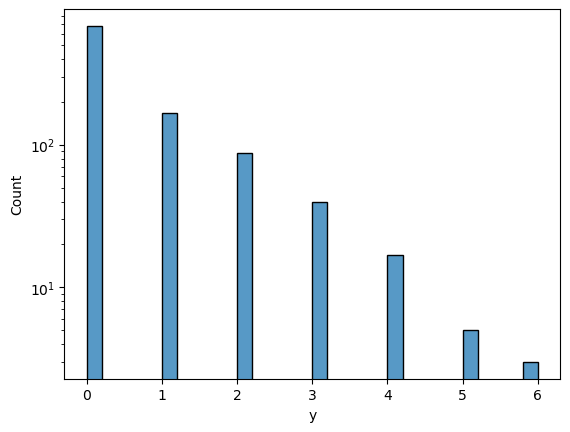

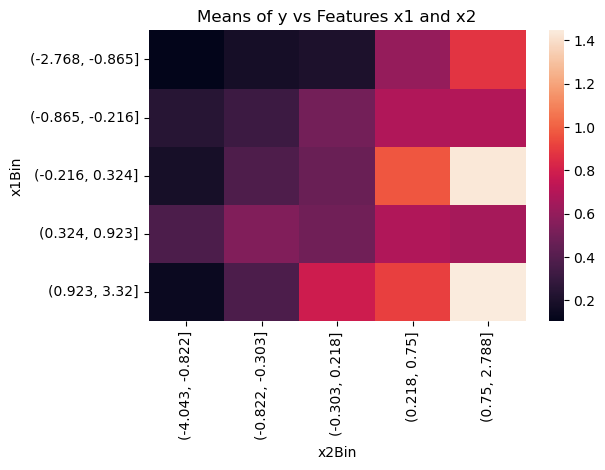

In [10]:
alpha, beta = (.5, .5)
df = generate_data((alpha, beta), 1000)
plot_generated_data(df)

In [11]:
df.head()

,x1,x2,y
0,-0.334790,-0.481637,0
1,0.779923,2.026997,1
2,-1.348442,1.284227,0
3,0.845573,0.098662,0
4,-0.211554,-1.250539,0


In [12]:
train = torch.tensor(df.values, dtype=torch.float)
y, x1, x2 = train[:, 2], train[:, 0], train[:, 1]

In [13]:
y

tensor([0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
        0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 4., 0., 0., 0., 1., 1.,
        0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 3., 2., 0., 0., 1., 5.,
        0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 3., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
        0., 1., 4., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 4., 0., 0.,
        0., 1., 0., 0., 2., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 1., 0., 0., 6.,
        0., 0., 0., 2., 2., 0., 4., 2., 

In [14]:
x1

tensor([-3.3479e-01,  7.7992e-01, -1.3484e+00,  8.4557e-01, -2.1155e-01,
        -1.4721e+00,  1.0979e+00,  4.4333e-01,  5.3333e-01, -1.7096e+00,
         1.1182e+00, -2.0823e+00, -4.2811e-01, -1.0982e+00, -8.5152e-01,
        -9.9614e-03,  8.2758e-01,  9.4026e-02,  7.9046e-01,  4.9103e-01,
         2.8728e-01,  1.9060e-01,  9.5670e-01,  2.3803e+00,  1.6586e-01,
         1.5961e+00, -7.3035e-01, -6.0986e-01, -7.3403e-01,  1.7482e+00,
         1.0566e+00, -1.3978e+00,  1.1758e+00,  1.4436e+00, -1.4961e+00,
        -9.2977e-01,  1.4541e+00,  1.0332e+00,  2.4969e+00, -1.1600e+00,
        -1.1691e+00,  5.3456e-02, -1.5090e+00, -3.0822e-01, -9.9689e-01,
         3.4151e-01, -4.3026e-01, -4.6900e-01,  1.5534e+00,  1.4434e+00,
        -5.2316e-01,  2.0248e+00,  4.4238e-01, -7.4086e-01, -2.0481e-01,
         9.0652e-01,  1.3996e+00,  4.0688e-01, -1.2185e+00, -3.9427e-01,
         1.0994e+00, -5.6326e-02, -1.9098e+00,  9.2809e-02,  7.8667e-01,
         9.4859e-01,  5.0955e-02, -8.6023e-01, -1.3

In [15]:
x2

tensor([-4.8164e-01,  2.0270e+00,  1.2842e+00,  9.8662e-02, -1.2505e+00,
         3.1529e-01,  2.9717e-01, -2.1572e+00, -1.4882e+00, -5.5917e-01,
         1.2541e-02, -6.7263e-01, -6.1458e-01,  6.3558e-01, -1.0424e+00,
         6.8429e-01,  8.9655e-01,  4.9230e-01,  6.4039e-02,  7.5659e-01,
        -1.8011e+00, -3.7171e+00,  1.3318e-01, -2.6319e+00,  4.7284e-01,
        -6.5918e-01,  2.4097e-01,  1.0096e+00, -4.4128e-01, -2.2413e+00,
        -1.2098e+00, -1.0415e+00,  1.0490e+00,  1.1354e+00, -1.1260e+00,
         4.4994e-01, -5.3581e-01,  2.1336e+00, -6.4868e-01,  5.7652e-01,
         1.6526e-01, -1.0867e+00,  2.5751e-01,  1.3336e+00, -7.8220e-01,
        -1.2459e+00,  3.2460e-01, -5.5618e-01,  4.1584e-01,  1.3108e-01,
        -1.6899e-01, -1.3842e+00,  2.4349e-01,  1.2442e+00, -1.0726e-01,
         2.2943e-01, -8.9582e-01,  2.0910e+00, -5.3357e-01,  7.9178e-02,
         8.5144e-01, -4.9925e-01, -1.8739e-01,  3.6091e-01,  2.4360e+00,
         1.4350e+00,  6.4716e-01,  4.9625e-02,  3.0

In [16]:
y

tensor([0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0.,
        0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 4., 0., 0., 0., 1., 1.,
        0., 2., 1., 0., 0., 0., 0., 0., 2., 0., 0., 2., 3., 2., 0., 0., 1., 5.,
        0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 3., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0.,
        0., 1., 4., 1., 0., 0., 1., 2., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
        0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 0., 4., 0., 0.,
        0., 1., 0., 0., 2., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 1., 0., 0., 6.,
        0., 0., 0., 2., 2., 0., 4., 2., 

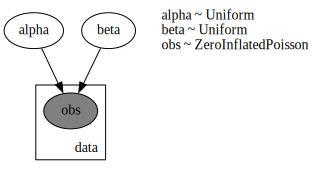

In [17]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(x1, x2, y = None):

    alpha = pyro.sample("alpha", dist.Uniform(-1, 1))
    beta = pyro.sample("beta", dist.Uniform(-1, 1))

    gate = 1 - torch.sigmoid(torch.mul(alpha, x1))
    rate = torch.exp(torch.mul(beta, x2))

    # iszero = pyro.sample("iszero", dist.Bernoulli(gate))
    # ywithoutzero = pyro.sample("ywithoutzero", dist.Poisson(rate))

    with pyro.plate("data", len(x2)):
               
        # return torch.mul(iszero, ywithoutzero)
        
        return pyro.sample("obs", dist.ZeroInflatedPoisson(gate = gate, rate = rate), obs=y)

pyro.render_model(simple_model, model_args=(x1, x2, y), render_distributions=True, render_params=True)

In [18]:
simple_model

<function __main__.simple_model(x1, x2, y=None)>

Elbo loss: 1051.256910085678
Elbo loss: 1051.6976273059845
Elbo loss: 1029.9509209394455
Elbo loss: 1020.0010328292847
Elbo loss: 1000.3634464740753
Elbo loss: 1000.397669672966
Elbo loss: 989.1297017335892
Elbo loss: 980.3559262752533
Elbo loss: 984.3751466274261
Elbo loss: 981.7711222171783
Elbo loss: 970.5884426832199
Elbo loss: 978.6028294563293
Elbo loss: 961.4281322956085
Elbo loss: 970.1612049341202
Elbo loss: 967.8584928512573
Elbo loss: 968.8341232538223
Elbo loss: 965.606685757637
Elbo loss: 966.6733689308167
Elbo loss: 960.1862924098969
Elbo loss: 961.5576575994492
Elbo loss: 959.9160158634186
Elbo loss: 960.3230535984039
Elbo loss: 959.4781577587128
Elbo loss: 958.6792837381363
Elbo loss: 958.3914022445679
Elbo loss: 959.1248054504395
Elbo loss: 959.4301038980484
Elbo loss: 959.2427765130997
Elbo loss: 958.6338266134262
Elbo loss: 958.7564468383789


CPU times: user 5.36 s, sys: 36.1 ms, total: 5.4 s
Wall time: 5.85 s


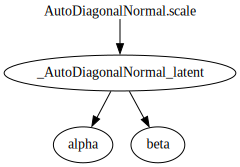

In [25]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoDiagonalNormal(simple_model)
adam = pyro.optim.Adam({"lr": 0.001})  
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(simple_model, auto_guide, adam, elbo)

losses = []
for step in range(3000):  # Consider running for more steps.
    loss = svi.step(x1, x2, y)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

pyro.render_model(auto_guide, model_args=(x1, x2, y), render_params=True)

Text(0, 0.5, 'ELBO loss')

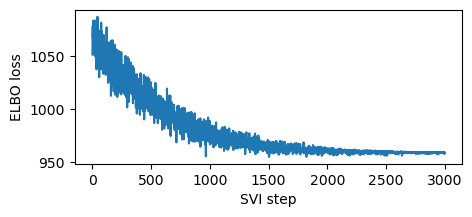

In [26]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

In [27]:
for name, value in pyro.get_param_store().items():
    print(name, (pyro.param(name).data.cpu().numpy()))
    # print(name, pyro.param(name).item())

AutoDiagonalNormal.loc [0.8024696 1.2144899]
AutoDiagonalNormal.scale [0.21456657 0.10917425]


In [28]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(x1, x2)

In [29]:
print("alpha mean: ", samples['alpha'].mean().item())
print("alpha std: ", samples['alpha'].std().item())
print("beta mean: ", samples['beta'].mean().item())
print("beta std: ", samples['beta'].std().item())

alpha mean:  0.3782699704170227
alpha std:  0.08797986060380936
beta mean:  0.5411325693130493
beta std:  0.03985483944416046


(array([ 2.,  1., 10., 10., 16., 31., 38., 62., 70., 90., 88., 90., 85.,
        76., 53., 38., 19., 13.,  6.,  2.]),
 array([0.09902465, 0.12512414, 0.15122363, 0.17732313, 0.20342262,
        0.22952211, 0.25562161, 0.28172109, 0.30782059, 0.33392006,
        0.36001956, 0.38611907, 0.41221854, 0.43831804, 0.46441752,
        0.49051702, 0.51661652, 0.54271603, 0.56881547, 0.59491497,
        0.62101448]),
 <BarContainer object of 20 artists>)

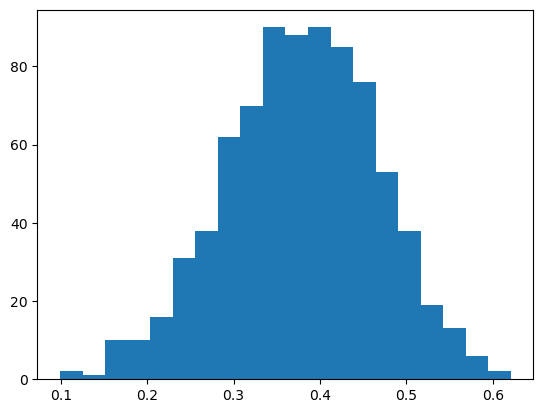

In [30]:
plt.hist(samples['alpha'].detach().numpy(), bins=20)

(array([  1.,   0.,   0.,   0.,   2.,   7.,  14.,  21.,  41.,  55.,  85.,
        120., 118., 104.,  91.,  66.,  45.,  19.,   8.,   3.]),
 array([0.35848105, 0.37317008, 0.38785911, 0.40254813, 0.41723716,
        0.43192619, 0.44661522, 0.46130425, 0.47599328, 0.4906823 ,
        0.50537133, 0.52006036, 0.53474939, 0.54943842, 0.56412745,
        0.57881647, 0.5935055 , 0.60819453, 0.62288356, 0.63757259,
        0.65226161]),
 <BarContainer object of 20 artists>)

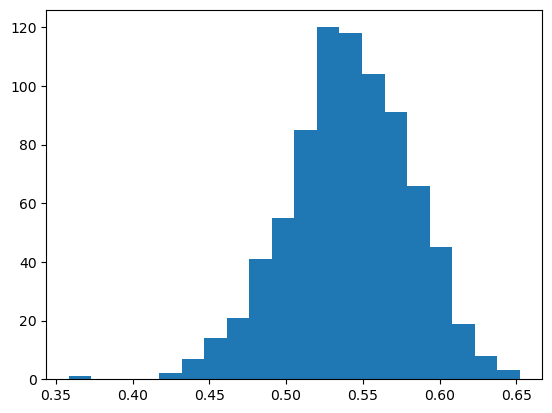

In [31]:
plt.hist(samples['beta'].detach().numpy(), bins=20)

In [32]:
predictive = pyro.infer.Predictive(simple_model, guide=auto_guide, num_samples=800)
svi_samples = predictive(x1, x2)
svi_y = svi_samples["obs"]

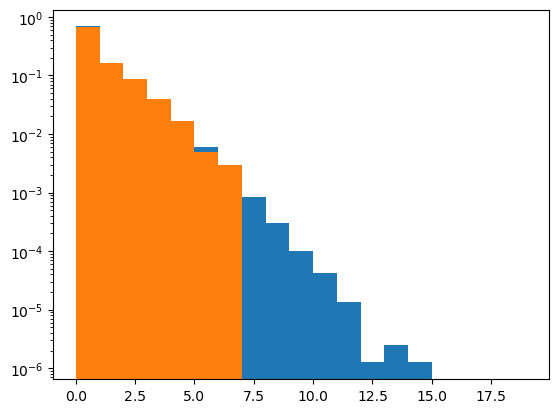

In [33]:
plt.hist(svi_samples["obs"].detach().numpy().flatten(), bins=range(20), density = True)
plt.yscale('log')
plt.hist(y.detach().numpy().flatten(), bins=range(20), density = True)
plt.yscale('log')


In [34]:
predictions = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "y_mean": svi_y.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_y.kthvalue(int(len(svi_y) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_y.kthvalue(int(len(svi_y) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_y": y,
})

predictions.head()

,x1,x2,y_mean,y_perc_5,y_perc_95,true_y
0,-0.334790,-0.481637,0.35875,0.0,2.0,0.0
1,0.779923,2.026997,1.75500,0.0,6.0,1.0
2,-1.348442,1.284227,0.66375,0.0,3.0,0.0
3,0.845573,0.098662,0.60250,0.0,2.0,0.0
4,-0.211554,-1.250539,0.23125,0.0,1.0,0.0


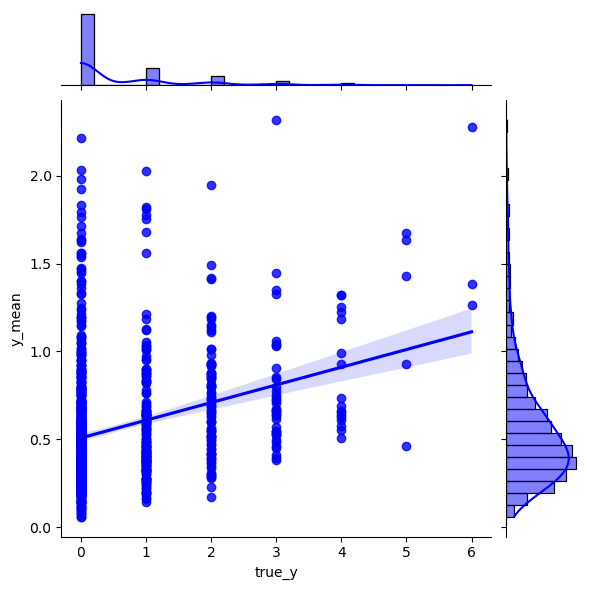

In [35]:
sns.jointplot(x="true_y", y="y_mean", data=predictions, kind="reg", color="b")